# Chapter 06: Regression and Regularization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# generate the data
np.random.seed(12)                               # comment out this line to generate a different dataset
m = 15
x = np.random.uniform(-1,1,m)
x.sort()
x[0] = -1
x[-1] = 1
y = x**3 - 4*x**2 + x + np.random.normal(0,1,m)

Using polynomials of high degree leads to overfitting

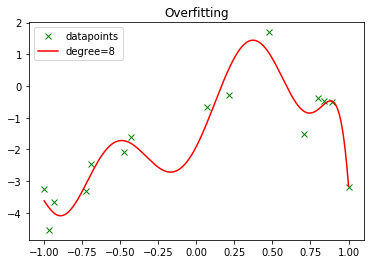

In [3]:
deg = 8
coefs = np.polyfit(x, y, deg)
grid = np.linspace(-1,1,500)
poly_over = np.poly1d(coefs)
plt.plot(x,y,'gx',grid,poly_over(grid),'r-')
plt.legend(labels=['datapoints','degree={}'.format(deg)],loc='best')
plt.title('Overfitting')
plt.show()

Using the Tikhonov regularization to avoid overfitting. Tikhonov regularization is 
$$ \mathop{\mathrm{minimize}}_{w\in\mathbb{R}^{d+1}} \| \widetilde{X}^\top w-y\|_2^2 + \lambda^2\|w\|_2^2. $$

Above minimization program can be solved by interpreting as the following standard least squares problem
$$ \mathop{\mathrm{minimize}}_{w\in\mathbb{R}^{d+1}} \left\| \left[\begin{matrix} \widetilde{X}^\top \\ \hline \lambda \mathop{\mathrm{Id}}\end{matrix}\right]w-\left[\begin{matrix} y \\ \hline 0\end{matrix}\right] \right\|_2^2. $$

In [4]:
import cvxpy as cp

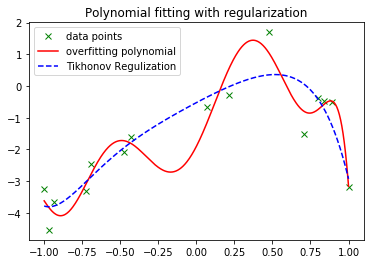

In [5]:
# defining augmented data matrix X_aug 
X_aug = np.zeros((len(x),deg+1))
for i in range(deg+1):
    X_aug[:,i] = x**i

lamb = 0.1     # lamb is an important parameter

# defining the stacked matrix X_opt and vector y_opt in above standard least squares problem 
X_opt = np.row_stack((X_aug,lamb*np.identity(X_aug.shape[1])))    
y_opt = np.hstack((y,np.zeros(X_aug.shape[1])))

# defining the variables
w_tik = cp.Variable(X_aug.shape[1])
c = cp.Variable(1)

# defining objective function and constraints
objective = cp.Minimize(c)
constraints = [cp.norm(X_opt@w_tik-y_opt,2)<=c]

tik = cp.Problem(objective,constraints)
tik.solve()

# getting coefficient vector w_tik and plotting regularized polynomial 
coef_tik = w_tik.value[::-1]
poly_tik = np.poly1d(coef_tik)
plt.plot(x,y,'gx',grid,poly_over(grid),'r-',grid,poly_tik(grid),'b--')
plt.legend(labels=['data points','overfitting polynomial','Tikhonov Regulization'])
plt.title('Polynomial fitting with regularization')
plt.show()

Using the square of the Lasso regularizer to avoid overfitting. The square of the Lasso regularizer is 
$$ \mathop{\mathrm{minimize}}_{w\in\mathbb{R}^{d+1}} \| \widetilde{X}^\top w-y\|_2^2 + \lambda^2\|w\|_1^2. $$

The square of the Lasso regularizer can be sreformulated as the nonnegative least squares problem
$$ \mathop{\mathrm{minimize}}_{w^+,w^-\in\mathbb{R}^{d+1}} \left\| \left[\begin{matrix} \widetilde{X}^\top & | & -\widetilde{X}^\top \\ \hline \lambda \mathbb{1}^\top & | & \lambda \mathbb{1}^\top \end{matrix}\right] \left[\begin{matrix} w^+ \\ \hline w^-\end{matrix}\right]-\left[\begin{matrix} y \\ \hline 0\end{matrix}\right] \right\|_2^2 \quad \mbox{ subject to } w^+\geq0, w^-\geq0.$$

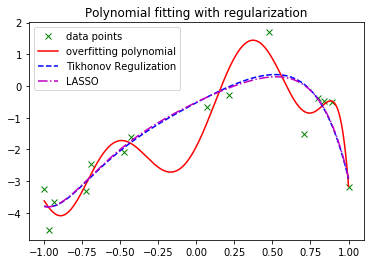

The number of non-zero coefficient is  5


In [6]:
lamb = 0.1    # lamb is an important parameter

# defining the stacked matrix X_opt and vector y_opt for above nonnegative least squares problem 
X_opt = np.row_stack((np.hstack((X_aug,-X_aug)),
                  lamb*np.ones((1,2*X_aug.shape[1]))))
y_opt = np.hstack((y,0))

# defining the variables
w_lasso = cp.Variable(2*X_aug.shape[1],pos=True)
c = cp.Variable(1)

# defining the objective function and constraints
objective = cp.Minimize(c)
constraints = [cp.norm(X_opt@w_lasso-y_opt,2)<=c]

lasso = cp.Problem(objective, constraints)
lasso.solve()

# computing coefficient vector coef_lasso and plotting regularized polynomial 
coef_lasso = w_lasso.value[0:X_aug.shape[1]] - w_lasso.value[X_aug.shape[1]:2*X_aug.shape[1]]
coef_lasso = coef_lasso[::-1]
poly_lasso = np.poly1d(coef_lasso)
plt.plot(x,y,'gx',grid,poly_over(grid),'r-',grid,poly_tik(grid),'b--',grid,poly_lasso(grid),'m-.')
plt.legend(labels=['data points','overfitting polynomial','Tikhonov Regulization','LASSO'])
plt.title('Polynomial fitting with regularization')
plt.show()

# Check the sparsity of the coefficient
print('The number of non-zero coefficient is ',sum(abs(coef_lasso)>1e-5))